In [1]:
import clip
import json
import os
import torch
import trimesh
import time
import optuna
from torchvision.transforms import Compose, Normalize, Resize, CenterCrop, InterpolationMode
import multiprocess
import math
from functools import partial
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

from torch.optim import Adam
from utils.pipeline import forward, get_latent_mean_std, get_latent_from_text

torch.cuda.empty_cache()

Mesh Tracing Algorithm

In [2]:
# --- Rendering Function ---

def phong_model(sdf, points, camera_position, phong_params, light_params, mesh_path, index_tri=None):
    
    # Option 1: Use SDF
    #normals = estimate_normals(sdf, points)
    # Option 2: Use Mesh
    normals = mesh_normals(mesh_path, index_tri)
    view_dirs = points - camera_position 
    light_dir_1 = light_params["light_dir_1"].repeat(points.shape[0], 1) 
    light_dir_p = points - light_params["light_pos_p"].repeat(points.shape[0], 1)
    
    # Normalize all vectors
    normals = (normals.T / torch.norm(normals, dim=-1)).T
    light_dir_norm_1 = (light_dir_1.T / torch.norm(light_dir_1, dim=-1)).T
    light_dir_norm_p = (light_dir_p.T / torch.norm(light_dir_p, dim=-1)).T
    view_dir_norm = (view_dirs.T / torch.norm(view_dirs, dim=-1)).T
    
    # Ambient
    ambient = phong_params["ambient_coeff"] * light_params["amb_light_color"] 
    ambient_refl = ambient.repeat(points.shape[0], 1)
    
    # Area light
    diffuse_1 = phong_params["diffuse_coeff"] * torch.clamp(torch.sum(-light_dir_norm_1 * normals, dim=-1), min=0.0) * light_params["light_intensity_1"] # [N]
    diffuse_refl_1 = torch.matmul(diffuse_1.unsqueeze(1), light_params["light_color_1"].unsqueeze(0)) # [N, 3]
    reflect_dir_1 = light_dir_norm_1 + (2 * normals.T * torch.clamp(torch.sum(-light_dir_norm_1 * normals, dim=-1), min=0.0)).T
    specular_1 = phong_params["specular_coeff"] * torch.pow(torch.clamp(torch.sum(reflect_dir_1 * -view_dir_norm, dim=-1), min=0.0), phong_params["shininess"]) * light_params["light_intensity_1"] # [N]
    specular_refl_1 = torch.matmul(specular_1.unsqueeze(1), light_params["light_color_1"].unsqueeze(0)) # [N, 3]
    
    
    # Point light
    diffuse_p = phong_params["diffuse_coeff"] * torch.clamp(torch.sum(-light_dir_norm_p * normals, dim=-1), min=0.0) * light_params["light_intensity_p"]  # [N]
    diffuse_refl_p = torch.matmul(diffuse_p.unsqueeze(1), light_params["light_color_p"].unsqueeze(0)) # [N, 3]
    reflect_dir_p = light_dir_norm_p + (2 * normals.T * torch.clamp(torch.sum(-light_dir_norm_p * normals, dim=-1), min=0.0)).T
    specular_p = phong_params["specular_coeff"] * torch.pow(torch.clamp(torch.sum(reflect_dir_p * -view_dir_norm, dim=-1), min=0.0), phong_params["shininess"]) * light_params["light_intensity_p"] # [N]
    specular_refl_p = torch.matmul(specular_p.unsqueeze(1), light_params["light_color_p"].unsqueeze(0)) # [N, 3]


    return ambient_refl + diffuse_refl_1 + specular_refl_1 + diffuse_refl_p + specular_refl_p 

def estimate_normals(sdf, points, epsilon=1e-3):
    sdf_inputs = torch.concat([points,
                              points + torch.tensor([epsilon, 0, 0]),
                              points + torch.tensor([0, epsilon, 0]),
                              points + torch.tensor([0, 0, epsilon])])

    sdf_values = sdf(sdf_inputs).reshape(4, -1)

    # Calculate the gradient using finite differences
    gradient = sdf_values[1:] - sdf_values[0]

    # Normalize the gradient to obtain the estimated normal
    normal = gradient / torch.norm(gradient, p=2, dim=0)

    return normal.T

def sphere_trace(sdf, camera_position, norm_directions, max_length):
    N = norm_directions.shape[0]
    positions = camera_position.unsqueeze(dim=0).repeat(N, 1) # [N, 3]
    total_distances = torch.zeros(N)
    last_distances = torch.ones(N)

    for _ in range(20):
        #mask = torch.logical_and(total_distances < max_length, last_distances > 1e-3)
        not_reached_max_distance = total_distances < max_length
        not_hit_target = torch.abs(last_distances) > 1e-3
        mask = torch.logical_and(not_reached_max_distance, not_hit_target)
        if torch.all(torch.logical_not(mask)):
            break
        distances = sdf(positions[mask])
        steps = (norm_directions[mask].T * distances).T
        positions[mask] += steps
        total_distances[mask] += distances
        last_distances[mask] = distances

    #positions[total_distances > max_length] *= torch.nan
    return positions, total_distances < max_length

def mesh_trace(mesh_path, ray_starts, ray_directions):
    mesh = trimesh.load_mesh(mesh_path)
    
    ray_origins = ray_starts.repeat(ray_directions.shape[0], 1)
    
    intersections, index_ray, index_tri = mesh.ray.intersects_location(ray_origins, ray_directions, multiple_hits=False) 
    
    mask = torch.zeros(ray_directions.shape[0], dtype=torch.bool)
    mask[index_ray] = True
    
    points = torch.as_tensor(intersections, dtype=torch.float32)

    return points, mask, index_tri


def mesh_normals(mesh_path, index_tri):
    mesh = trimesh.load_mesh(mesh_path)
    all_normals = mesh.face_normals
    normals = all_normals[index_tri]
    normals_torch = torch.from_numpy(normals).to(dtype=torch.float32)
    
    return normals_torch

def render(model, lat_rep, camera_params, phong_params, light_params, mesh_path=None):
    
    def sdf(positions):
        nphm_input = torch.reshape(positions, (1, -1, 3))
        distance, _ = model(nphm_input, torch.reshape(lat_rep, (1, 1, -1)), None)
        return distance.squeeze()

    pu = camera_params["resolution_x"]
    pv = camera_params["resolution_y"]
    image = phong_params["background_color"].repeat(pu * pv, 1)
    
    angle_radians = torch.deg2rad_(torch.tensor(camera_params["camera_angle"]))
    camera = torch.tensor([torch.sin(angle_radians), 0, torch.cos(angle_radians)])
    camera_position = camera * (camera_params["camera_distance"] + camera_params["focal_length"]) / camera.norm()
    
    # Normalize the xy value of the current pixel [-0.5, 0.5]
    u_norms = ((torch.arange(pu) + 0.5) / pu - 0.5) * pu/pv
    v_norms = 0.5 - (torch.arange(pv) + 0.5) / pv

    # Calculate the ray directions for all pixels
    directions_unn = torch.cat(torch.meshgrid(u_norms, v_norms, torch.tensor(-camera_params["focal_length"]), indexing='ij'), dim=-1) 
    directions_unn = directions_unn.reshape((pu*pv, 3)) # [pu, pv, 3] --> [pu*pv, 3] (u1, v1, f)(u1, v2, f)...(u2, v1, f)...

    # rotate about y-axis
    rotation_matrix = torch.tensor([[torch.cos(angle_radians), 0, torch.sin(angle_radians)],
                                    [0, 1, 0],
                                    [-torch.sin(angle_radians), 0, torch.cos(angle_radians)]])
    rotated_directions = torch.matmul(directions_unn, rotation_matrix.T)
    
    transposed_directions = rotated_directions.T #transpose is necessary for normalization
    directions = (transposed_directions / transposed_directions.norm(dim=0)).T # [pu*pv, 3]

    # Option 1: Use SDF
    #hit_positions, hit_mask = sphere_trace(sdf, camera_position, directions, camera_params['max_ray_length'])
    # Option 2: Use Mesh
    intersections, hit_mask, index_tri = mesh_trace(mesh_path, camera_position, directions) 
    
    # Option 1: Use SDF
    #reflections = phong_model(sdf, hit_positions[hit_mask], camera_position, phong_params, light_params, mesh_path)
    # Option 2: Use Mesh
    reflections = phong_model(sdf, intersections, camera_position, phong_params, light_params, mesh_path, index_tri) # mesh alternative

    # Assign a color for objects
    image[hit_mask] = torch.mul(reflections, phong_params["object_color"].repeat(reflections.shape[0], 1))
    image = torch.clamp(image, max=1.0)
    image = image.reshape(pu, pv, 3).transpose(0, 1)


    return image

In [3]:
# --- Get Data Annotations ---

path_to_head_annotations = '/Users/katharinaschmid/Text2Head/rendering_data/head_annotations.json'
with open(path_to_head_annotations) as f:
    data = json.load(f)

# --- Prepare Indices ---

# Identity: Gender
male_indices = [index for index, head in enumerate(data['heads']) if head['gender'] == 'man']
female_indices = [index for index, head in enumerate(data['heads']) if head['gender'] == 'woman']

# Identity: Age
young_indices = [index for index, head in enumerate(data['heads']) if head['age'] == 'young']
old_indices = [index for index, head in enumerate(data['heads']) if head['age'] == 'old']

# Identity: Ethnicity
caucasian_indices = [index for index, head in enumerate(data['heads']) if head['ethnicity'] == 'Caucasian'] 
asian_indices = [index for index, head in enumerate(data['heads']) if head['ethnicity'] == 'Asian'] 

# Identity: Hairstyle
hat_indices = [index for index, head in enumerate(data['heads']) if head['hairstyle'] == 'hat']
ponytail_indices = [index for index, head in enumerate(data['heads']) if head['hairstyle'] == 'ponytail']
straight_hair_indices = [index for index, head in enumerate(data['heads']) if head['hairstyle'] == 'straight hair']
curly_hair_indices = [index for index, head in enumerate(data['heads']) if head['hairstyle'] == 'curly hair']

# Identity: Beard
beard_indices = [index for index, head in enumerate(data['heads']) if head['beard'] == 'yes']
no_beard_indices = [index for index, head in enumerate(data['heads']) if head['beard'] == 'no']

In [4]:
# --- CLIP Preprocessing --- # 
clip_tensor_preprocessor = Compose([
    Resize(224, interpolation=InterpolationMode.BICUBIC, antialias=None),
    CenterCrop(224),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# --- Get Hyperparameters ---
camera_params = {
    "camera_distance": 0.21,
    "camera_angle": 45.,
    "focal_length": 2.57,
    "max_ray_length": 3,
    # Image
    "resolution_y": 120,
    "resolution_x": 120
}

phong_params = {
    "ambient_coeff": 0.51,
    "diffuse_coeff": 0.75,
    "specular_coeff": 0.64,
    "shininess": 0.5,
    # Colors
    "object_color": torch.tensor([0.53, 0.24, 0.64]),
    "background_color": torch.tensor([0.36, 0.77, 0.29])
}

light_params = {
    "amb_light_color": torch.tensor([0.9, 0.16, 0.55]),
    # light 1
    "light_intensity_1": 1.42,
    "light_color_1": torch.tensor([0.8, 0.97, 0.89]),
    "light_dir_1": torch.tensor([-0.6, -0.4, -0.67]),
    # light p
    "light_intensity_p": 0.62,
    "light_color_p": torch.tensor([0.8, 0.97, 0.89]),
    "light_pos_p": torch.tensor([1.19, -1.27, 2.24])
}

def get_image_embeddings(mesh_path, camera_params, phong_params, light_params):
    sdf = None
    lat_rep = None
    rendered_image = render(sdf, lat_rep, camera_params, phong_params, light_params, mesh_path)
    image_c_first = rendered_image.permute(2, 0, 1)
    image_preprocessed = clip_tensor_preprocessor(image_c_first).unsqueeze(0)
    image_features = model.encode_image(image_preprocessed) # [1, 512]
    
    return image_features

def get_gt_embeddings():
    
    # --- Render and Embed Images ---
    folder_path = '/Users/katharinaschmid/Text2Head/rendering_data/annotated_dataset/'
    file_list = sorted(os.listdir(folder_path))
    file_list = [file for file in file_list if not (file.startswith('.DS_Store') or file.endswith('.png'))]
    
    one_mesh_path = folder_path + file_list[0]
    sdf = None
    lat_rep = None
    rendered_image = render(sdf, lat_rep, camera_params, phong_params, light_params, one_mesh_path)
    plt.imshow(rendered_image.detach().numpy())
    plt.axis('off')  # Turn off axes
    plt.show()
    
    mesh_path_list = []
    for mesh in file_list:
        mesh_path_list.append(folder_path + mesh)
        
    with torch.no_grad():
        pool = multiprocess.Pool(processes=None)
        simplified_func = partial(get_image_embeddings, camera_params=camera_params, phong_params=phong_params, light_params=light_params) # creates a simplified version of the function 'get_image_embeddings' where certain arguments are fixed to specific values
        image_embeddings_list = pool.map(simplified_func, mesh_path_list)

        image_embeddings = torch.cat(image_embeddings_list, dim=0)
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

    return image_embeddings

def gt_image_similarities(image_embeddings):

    male_embeddings = image_embeddings[male_indices, :]
    male_similarity = torch.matmul(male_embeddings, male_embeddings.T)
    # Exclude diagonal elements (self-similarity)
    num_samples = male_similarity.size(0)
    mask = torch.eye(num_samples, dtype=torch.bool)
    male_similarity_without_self = male_similarity[~mask].view(num_samples, num_samples - 1)
    # Compute mean without self-similarity
    mean_male_similarity = male_similarity_without_self.mean()
    #print('male_similarity', male_similarity)
    print('gt mean male', mean_male_similarity.item())

    female_embeddings = image_embeddings[female_indices, :]
    female_similarity = torch.matmul(female_embeddings, female_embeddings.T)
    # Exclude diagonal elements (self-similarity)
    num_samples = female_similarity.size(0)
    mask = torch.eye(num_samples, dtype=torch.bool)
    female_similarity_without_self = female_similarity[~mask].view(num_samples, num_samples - 1)
    # Compute mean without self-similarity
    mean_female_similarity = female_similarity_without_self.mean()
    #print('female_similarity', female_similarity)
    print('gt mean female', mean_female_similarity.item())

    asian_embeddings = image_embeddings[asian_indices, :]
    asian_similarity = torch.matmul(asian_embeddings, asian_embeddings.T)
    # Exclude diagonal elements (self-similarity)
    num_samples = asian_similarity.size(0)
    mask = torch.eye(num_samples, dtype=torch.bool)
    asian_similarity_without_self = asian_similarity[~mask].view(num_samples, num_samples - 1)
    # Compute mean without self-similarity
    mean_asian_similarity = asian_similarity_without_self.mean()
    #print('asian_similarity', asian_similarity)
    print('gt mean asian', mean_asian_similarity.item())

def render_and_embed(prompt):
    lat_mean, lat_std = get_latent_mean_std()
    lat_rep = (torch.randn(lat_mean.shape) * lat_std * 0.85 + lat_mean).detach().requires_grad_(True)

    hparams = {
        'resolution': 180,
        'n_iterations': 80,
        'optimizer_lr': 1.4e-3,
        'lr_scheduler_factor': 0.53,
        'lr_scheduler_patience': 5,
        'lr_scheduler_min_lr': 2.6e-5
    }
    best_latent, best_CLIP_score, best_prob_score, hist = get_latent_from_text(prompt, hparams, init_lat=lat_rep)
    print('best CLIP Score', best_CLIP_score)

    with torch.no_grad():
        _, _, image = forward(best_latent, prompt, camera_params, phong_params, light_params)
        plt.imshow(image.detach().numpy())
        plt.axis('off')  # Turn off axes
        plt.show()
        image_c_first = image.permute(2, 0, 1)
        image_preprocessed = clip_tensor_preprocessor(image_c_first).unsqueeze(0)
        image_features = model.encode_image(image_preprocessed) # [1, 512]
    
    return image_features

def eval_similarity(gt_embeddings):
    #gt_male_embeddings = gt_embeddings[male_indices, :]
    optimized_embeddings = []
    image1 = render_and_embed('A man')
    optimized_embeddings.append(image1)
    image2 = render_and_embed('A male person')
    optimized_embeddings.append(image2)
    #male_similarity = torch.matmul(gt_male_embeddings, optimized_embeddings.T)
    print('male similarity mean')#, male_similarity.mean())

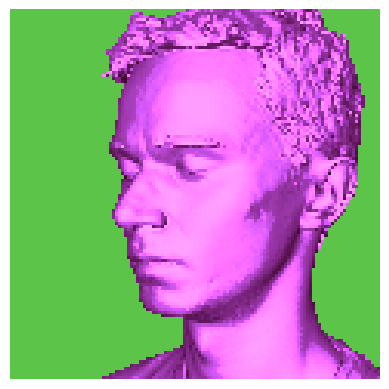

gt mean male 0.8775867223739624
gt mean female 0.884286105632782
gt mean asian 0.8916783928871155


In [6]:
gt_image_embeddings = get_gt_embeddings()
gt_image_similarities(gt_image_embeddings)

In [6]:
gt_image_embeddings = None
eval_similarity(gt_image_embeddings)

/opt/anaconda3/envs/NPHM/lib/python3.9/site-packages/torch/profiler/profiler.py:403: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
  0%|          | 0/80 [00:21<?, ?it/s]


KeyboardInterrupt: 

CLIP image similarities of ground truth data:
male: 87.76
female: 88.42
asian: 89.19